## A/B Test Results analysis

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.For this project, I've worked to understand the results of an A/B test run by an e-commerce website. My goal was to show my work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import the libraries.

In [2]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

C:\Users\alina\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
# Read in the `ab_data.csv` data. Store it in `df`.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
# How long did the test run for?
df['timestamp'] = pd.to_datetime(df.timestamp)
print('total run time: ', df.timestamp.max()-df.timestamp.min())

total run time:  21 days 23:59:49.081927


In [7]:
# Number of rows using shape
df.shape[0]

294478

In [8]:
# Computing unique number of id's usinf nunique function
df.user_id.nunique()

290584

In [9]:
converted = round(float(df.converted.mean()),4)
converted

0.1197

The number of times the `new_page` and `treatment` don't line up.

In [10]:
# Conditional statement to count number of rows where treatment group does not correspond with new landing page
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page')) == True].shape[0]

3893

Do any of the rows have missing values?

In [8]:
df.isnull().sum() # No null values in any column

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [11]:
# Import into df2 only rows which specify above conditions
df2 = df[((df.group == 'treatment') == (df.landing_page == 'new_page')) &
         ((df.group == 'control') == (df.landing_page == 'old_page'))]

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
# How many unique **user_id**s are in **df2**?
df2.user_id.nunique()

290584

In [14]:
# There is one **user_id** repeated in **df2**.  What is it?
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [15]:
# What is the row information for the repeat **user_id**? 
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# Drop the raw with an index 2893 and update the original data frame
df2 = df2.drop(df.index[2893]);

What is the probability of an individual converting regardless of the page they receive?

In [17]:
converted_prob = round(float(df2.converted.mean()),4)
converted_prob

0.1196

Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_prob = round(float((df2.query('group == "control"')['converted'] == 1).mean()),4)
control_prob

0.1204

Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment_prob = round(float((df2.query('group == "treatment"')['converted'] == 1).mean()),4)
treatment_prob

0.1188

What is the probability that an individual received the new page?

In [20]:
new_page_prob = round(float((df2.query('landing_page == "new_page"')['user_id'].nunique())/(df2.shape[0])),4)
new_page_prob

0.5001

**Summary:** There is a little difference between conversion probabilities, which can serve as statistical evidence that a new landing page leads to more conversions. The probablity of users converting in both control and treatment groups is also quite similar to the probability of users converting regardless of the page they received.  

Overal probability of an individual converting, regardelss of landing page type, is **11.96%**  
Control group has a conversion probability of **12.04%**  
Treatment groupgroup has a conversion probability of **11.88%**  
The probability of user receiving new landing page is **50.01%**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, my null and alternative hypotheses be:

$$H_0 : p_{new} - p_{old} \leq 0$$
$$H_1 : p_{new} - p_{old} > 0$$


Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. 

Use a sample size for each page equal to the ones in **ab_data.csv**.

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

In [21]:
# What are the P_old and P_new values
# Assuming P_new and P_old are equal, they will have exactly the same formulas and values
p_new = df2.query('converted == 1')['user_id'].nunique()/df2.shape[0]
p_new

0.11959708724499628

In [22]:
p_old = df2.query('converted == 1')['user_id'].nunique()/df2.shape[0]
p_old # The answer will be identical to p_new

0.11959708724499628

In [23]:
# n_new
# Number of unique users who received new landing page
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new 

145310

In [24]:
# n_old
# Number of unique users who received old landing page
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# Randomly alocate 0s and 1s with probability p_new under the null, in an array of a size n_new.
new_page_converted = np.random.binomial(1, p_new, n_new) # REVIEW
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# As above the same is performed for old landing page
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# Find difference, p_{new} - p_{old}, for simulated values from part (e) and (f).# 
diff = sum(new_page_converted == 1)/n_new - sum(old_page_converted == 1)/n_old
diff

-0.0010138855672165437

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = [] 
for i in range(1000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diffs.append(sum(new_page_converted ==1)/n_new - sum(old_page_converted==1)/n_old)

Plot a histogram of the **p_diffs**.

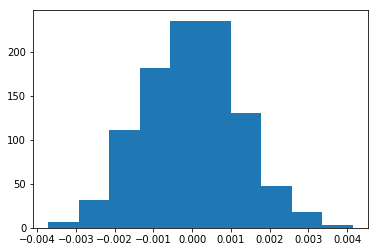

In [29]:
# Convert to array
p_diffs = np.array(p_diffs)
# Plotting
plt.hist(p_diffs);
# The plot apears to be normaly distributed around zero, as expected.

In [30]:
# Get dataframe with all records from treatment group
new_page_df = df2.query('landing_page == "new_page"')
# Compute conversion rate rate for treatment group
new_page_cr = new_page_df.query("converted == 1 ").user_id.nunique()/new_page_df.user_id.nunique()
# Display conversion rate
new_page_cr

0.11880806551510564

In [31]:
# Get dataframe with all records from control group
old_page_df = df2.query('landing_page == "old_page"')
# Compute conversion rate for control group
old_page_cr = old_page_df.query("converted == 1 ").user_id.nunique()/old_page_df.user_id.nunique()
# Display conversion rate
old_page_cr

0.1203863045004612

In [32]:
# Compute the observed difference under the null
obs_diff = new_page_cr - old_page_cr
obs_diff

-0.0015782389853555567

In [33]:
# Create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

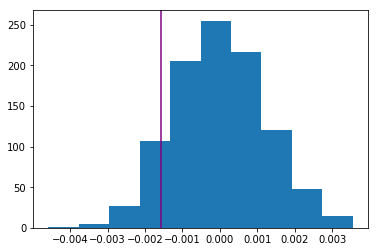

In [34]:
# Plot and see where the observed difference lies
plt.hist(null_vals);
plt.axvline(obs_diff, color='purple')

In [35]:
p_value = (null_vals > obs_diff).mean()
p_value # P-value is greater than 0.05 or 5%

0.90500000000000003

**Summary:** P-Value is a probability of observing our statistic or a more extreme statistic from the null hypothesis.  
The P-value computed above is greater than the Type I error threshhold of 5%. Thus we fail to reject the null hypothesis.

Statistical test preparation

In [36]:
# Create variable for Statistical tests
convert_old = df2.query('converted == 1' and 'landing_page == "old_page"')['user_id'].nunique()/df2['user_id'].nunique()
convert_new = df2.query('converted == 1' and 'landing_page == "new_page"')['user_id'].nunique()/df2['user_id'].nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

Sse `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
# Two tail test to determine if p_new and p_old are different from each other
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]))
# See the result
z_score, p_value 

(-6.1533660893407598e-17, 1.0)

In [38]:
# Test significance of z-score
norm.cdf(z_score)

0.5

In [39]:
# Tells us what our critical value at 95% confidence is
norm.ppf(1-(0.05/2))

1.959963984540054

**Answer:** The z-score of -6.153366 is less than critical value of 1.959963984540054. Thus, we fail to reject the null hypothesis, conversion rates for new and old lancing page have no statistical difference, this agrees with previous findings.

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will see that the result you acheived in the previous A/B test can also be acheived by performing regression. The response variables provided are of a categorical type. An occurence we need to predict is whether a user will convert on a new landing page or not, and how likely the conversion is to happen. Thus it is best to use the Logistic Regression model.

The goal is to use **statsmodels** to fit the regression model I specified in part I to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
# Create a dummy variable column for which page each user received
df2 = df2.join(pd.get_dummies(df2['landing_page']))

In [41]:
# Add ab_page column which reflects the values in the treatment column
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0


Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns in part to predict whether or not an individual converts.

In [42]:
# Attribution Error triggered by scipy version outdate has occured. 
# Possible solution is to run the scripts in another environment, after installing needed versions of scipy, 
# or remain in Jupyter and use following temporary resolution workaround code: https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Fit the Logistic regression model
df2['intercept'] = 1
# Logit regression model for conveted variable and ab_page
logit_mod1 = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        18:31:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [44]:
np.exp(-0.0150)

0.98511193960306265

**Summary:** The p-value associated with ab_page is 0.190, which once more is greater than the alpha threshold of 0.05, confirminf that difference between control and ab_page values do not provide us with a statistically significan results.
The p-value is different due to the following factors:

 - The null hypothesis used in Part II asumes the old landing page converts users more than the new page, i.e. $H_0: p_{new} \leq p_{old}$.  
We will fail to reject the null hyphothesis unless there is a prove that new page is definitely better at a Type I error rate of 5%, i.e. $H_1: p_{new} > p_{old}$.

 - In comparisson the null hypothesis in Part III of this document states there is no difference between the treatment and control groups, i.e. $H_0: p_{new} = p_{old}$  
Alternative hypotheses states that there is a statistical difference between the treatment and control groups i.e. $H_1: p_{new} \neq p_{old}$

Note: It is always a good idea to include other factor variables into the analysis, provided that they are not interrelated with original variables. Adding more factors into the analysis may give insights for a reason of conversion and allow to predict conversion probability more precisely. In terms of landing pages there are a lot of factors which could affect the conversion rate, e.g.: 
- Device type ( PC, tablet or mobile) and whether the landing page was adapted to the device.
- Localisation to suit users demands in a particular region or their language.
- Accessibility, whether a page completed all accessibility tests and is viewable by all users and across devices.
- Runtime of the test, which could determine novelty effect or resistance to change.  

Potential drawbacks of introducing more data into the model is a risk of interdependence between variables or multicollinearity, i.e. new variables might affect the given variables, which in turn will make interpretation of results more complex or potentially incorrect.

### Additional data
Now along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives.

In [45]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [46]:
# Which countries do we have in a countries data frame?
countries_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [47]:
# Join the clean ab_data with countries_df, use user_id as the new key
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
# Create dummies for the country values
df3 = df3.join(pd.get_dummies(df3['country']))
# We only need two dummy variables for the model
df3 = df3.drop('CA', axis = 1)
df3.head(2)

,country,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1,0,1


In [48]:
# Logit regression model for conveted and country, use CA as baseline
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK','US']])
results = logit_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 03 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        18:33:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [49]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [50]:
1/np.exp(-0.0149)

1.0150115583846535

**Summary:**  
It is worth noting that P values of the newly introduced variables are quite big, and are over the alpha threshold of 0.05.

For every unit decrease in new_page, convert will be 1.015 times as likely to happen in an old page, holding all other varible constant.  
In the UK conversion is 1.05 times as likely to take place as in Canada, holding all other varibles constant.  
And in the US cinversion is 1.04 times as likely to take place as in Canada, holding all other varibles constant.

Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.  Iwill create the necessary additional columns, and fit the new model.

In [51]:
# Adding higher order term to see interractions between new page and countries US and UK
df3['new_page_UK'] = df3['new_page']* df3['UK']
df3['new_page_US'] = df3['new_page']* df3['US']

In [52]:
### Fit my Linear Model And Obtain the Results
# Logit regression model for conveted and country, use CA as baseline
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept','ab_page','new_page_UK','new_page_US','UK','US']])
results = logit_mod3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Jul 2018   Pseudo R-squ.:               3.482e-05
Time:                        18:34:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page        -0.0674      0.052     -1.297      0.195      -0.169       0.034
new_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
new_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [53]:
# Interpret the Ligostic regression model results
np.exp(results.params)

intercept      0.134794
ab_page        0.934776
new_page_UK    1.081428
new_page_US    1.048001
UK             1.011854
US             1.017682
dtype: float64

**Results:** The P-values for each value in the results are over the alpha threshhold of 0.05, sugesting that these are not statistically significant.

Conversion is 1.08 times and 1.04 times more likely to happen among new landing page users in the UK and in the US respectively, when compared to Canada, holding all other varible constant.

Also in general users in the UK are 1.011 times more likely to convert, and the US users are 1.017 times more likely to convert, compared to users in Canada, holding all other varible constant.

Thus, the country a user accessed the new landing page from is not a statistically significant factor for conversion rate.

### Model Diagnostics

In [54]:
# Import sklearn model to split, test and score data, and fit data model 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [55]:
# Define X and y variables
X = df3[['new_page','old_page','ab_page','UK','US','new_page_UK','new_page_US']]
y = df3['converted']
# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logit_mod = LogisticRegression()
# logistic regression model fitting
logit_mod.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
y_pred = logit_mod.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2%}'.format(logit_mod.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 87.98%


In [57]:
# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) # The result is that we have 51129 correct predictions and 6988 incorrect predictions.

[[51129     0]
 [ 6988     0]]


In [58]:
precision_score(y_test, y_pred) #Assumption: the test data set is not very good fit for making predictions

C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [59]:
recall_score(y_test, y_pred)

0.0

C:\Users\alina\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\alina\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


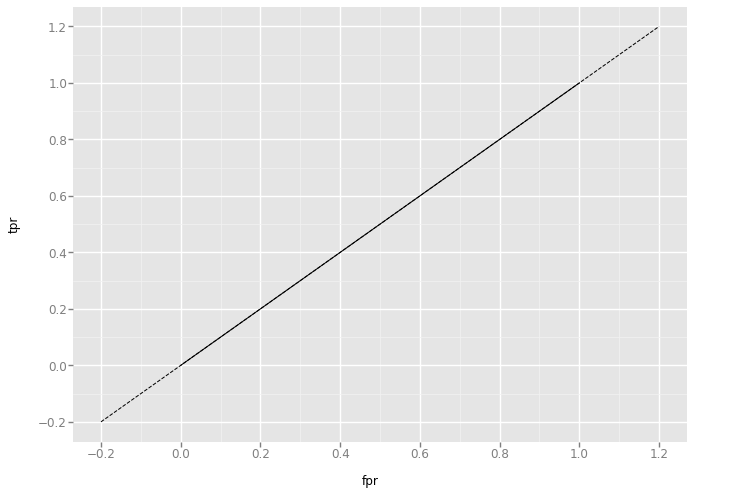

<ggplot: (-9223371917449907147)>

In [60]:
from ggplot import *
from sklearn.metrics import roc_curve, auc
%matplotlib inline

preds = logit_mod.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

<a id='conclusions'></a>
## Conclusions

We fail to regect the null hypothesis, as users were more likely to convert using old landing page. Furthermore, additional factors - countries - did not demonstrate to have significant effect on conversion rates.

Provided A/B testing data set is not a good fit for predicting conversions on a new landing page. Possible reasons among others are:  
1) Fuller data required. From data provided we can not see whether a new landing page is localised and adapted to suit requirements of the target audience.  
2) We do not have information about users apart from their unique IDs.  
3) The test results provided, span over 21 full days only, which is not long enough to see if reduced conversion rates on the new landing page were due to novelty effect or resistance to change, or in general any change to take place.  
4) Even though we observe on average a 12% conversion rate, we cannot see what is the conversion value, and thus cannot conclude with confidence whether conversion rate on new landing page actually brings more profit or not.  

### Resources
Majority of code is based on original Udacity code or external links to blogs given in the Udacity tutorials. apart from an error workaround dicussed below.  
**Attribution Error** triggered by scipy version outdate has occured. Possible solution is to run the scripts in another environment, after installing needed versions of scipy, or remain in Jupyter and use following temporary resolution workaround code found on https://github.com/statsmodels/statsmodels/issues/3931.  